## Classification German News with BERT

In this notebook I follow the example given by Joel in 
[Bert Fine tuning](https://colab.research.google.com/github/AdvancedNLP/encoder/blob/exercise/BERT_doctors_review.ipynb)

The example showed a binary classification problem where as the German Newsset is a multiclass classification.
Challenge was to get all the Tensorflow stuff correct.

---

Fine tuning of a pretrained Hugging Face transfomer
In this notebook we will be looking at the fine-tuning process of a BERT model that was previously pre-trained on a large german text corpus. We aim at building a classifier to predict doctor ratings from patients' text comments.

A detailed description of the German language reviews of doctors by patients 2019 dataset can be found here

For the feature creation and the modeling, we will use the Hugging Face implementation of transformers for Tensorflow 2.0. Transformers provides a general architecture implementation for several state of the art models in the natural language domain.

NOTE: This notebook and its implementation is heavily influenced by the data-drive Natural Language Processing of German texts blog post


### Results F1 Score
As a surprise the results (see last column) are even better as the one achieved with the SimpleTransformer model. Which should actually to same but more sophisticated.

![classification_results_with_bert_tf.png](classification_results_with_bert_tf.png)


Also check https://towardsdatascience.com/multi-class-classification-with-transformers-6cf7b59a033a 


In [ ]:
!pip install -U transformers==4.9.2

In [ ]:
!pip install 'fhnw-nlp-utils>=0.1.6'
!pip install pyarrow

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download


import numpy as np
import pandas as pd

In [3]:
file = "data/german_news_articles_original_train_and_test_tokenized.parq"
data_all = load_dataframe(file)

In [4]:
data_all.sample(3)

,text_original,label,split,text_clean,token_clean,token_lemma,token_stem,token_clean_stopwords
579,US-Außenminister traf Palästinenserpräsident A...,International,test,US Außenminister traf Palästinenserpräsident A...,"[us, außenminister, traf, palästinenserpräside...","[us-amerikanischen, außenminister, treffen, pa...","[us, aussenminist, traf, palastinenserprasiden...","[us, außenminister, traf, palästinenserpräside..."
3922,Sachwalterschaften werden meist von Verwandten...,Panorama,train,Sachwalterschaften werden meist von Verwandten...,"[sachwalterschaften, meist, verwandten, bekann...","[sachwalterschaften, meist, verwenden, bekenne...","[sachwalterschaft, meist, verwandt, bekannt, b...","[sachwalterschaften, meist, verwandten, bekann..."
1199,"5. August, 10:00 Uhr: Der GameStandard zeigt d...",Web,train,August Uhr Der GameStandard zeigt die Übertra...,"[august, uhr, gamestandard, zeigt, übertragung...","[august, uhr, gamestandard, zeigen, übertragun...","[august, uhr, gamestandard, zeigt, ubertrag, l...","[august, uhr, gamestandard, zeigt, übertragung..."


In [5]:
from transformers import BertTokenizer, TFBertModel

In [6]:
# We need to tokenize out news 
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

In [7]:
# As well we must label encode the classes -> Be aware that if not using One-Hot Encoding we well need 
# sparse_categorical_crossentropy as loss as opposed to  categorical_crossentropy if using One-Hot
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

data_all.drop(columns=['label_encoded', 'label_onehot'], errors='ignore', inplace=True)
data_all['label_encoded'] = encoder.fit_transform(data_all['label'])

num_labels = len(encoder.classes_)
print(f'Number of classes {num_labels}')

Number of classes 9


In [8]:
data_train_orig = data_all.loc[(data_all["split"] == "train")]
data_test_orig = data_all.loc[(data_all["split"] == "test")]

In [9]:
# As with all other models we will not use the test data during the training
# This makes f1 scores comparable
from sklearn.model_selection import train_test_split

train_ids, test_ids, train_labels, test_labels = train_test_split(
    data_train_orig, 
    data_train_orig["label_encoded"], 
    random_state=1, 
    test_size=0.25, 
    shuffle=True
)


<AxesSubplot:ylabel='Frequency'>

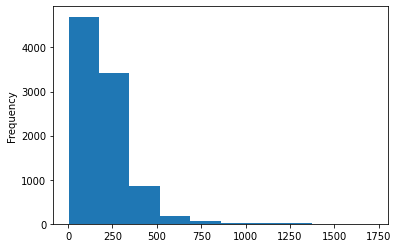

In [36]:
data_train_orig['token_clean'].apply(len).plot(kind='hist')

In [10]:
MAXLEN = 512

def tokenize(review):
  encoded = tokenizer.encode_plus(
      text=review,
      add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
      max_length=MAXLEN,  # Max length to truncate/pad
      padding='max_length',  # Pad sentence to max length
      return_attention_mask=False,  # attention mask not needed for our task
      return_token_type_ids=False,
      truncation=True, )
    
  return encoded['input_ids']

In [46]:
text = data_train_orig['text_clean'].iloc[0]
print(text)
print(f'\nThe first 5 entries of the tokenized string {tokenize(text)[0:5]}')

 Jähriger fällt wohl bis Saisonende aus Wien Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten Der im Winter aus Ried gekommene Jährige erlitt beim Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie wie eine Magnetresonanz Untersuchung am Donnerstag ergab Murg erhielt eine Schiene muss aber nicht operiert werden Dennoch steht ihm eine mehrwöchige Pause bevor 

The first 5 entries of the tokenized string [3, 112, 352, 519, 5483]


In [11]:
# Tokenize train and test data
import tqdm
train_input_ids = np.array([tokenize(review) for review in tqdm.tqdm(train_ids['text_clean'])])
test_input_ids = np.array([tokenize(review) for review in tqdm.tqdm(test_ids['text_clean'])])

100%|██████████| 2312/2312 [00:13<00:00, 176.93it/s]


In [12]:
# Had to reduce BATCH_SIZE to 4 otherwise on my GPU RTX-2060 I was always runnging into OOM
BATCH_SIZE = 4
EPOCHS = 4
LEARNING_RATE = 1e-5

In [13]:
import tensorflow as tf


train_dataset = (tf.data.Dataset.from_tensor_slices((train_input_ids, train_labels))
                    .shuffle(buffer_size=len(train_input_ids), reshuffle_each_iteration=True)
                    .repeat(EPOCHS)
                    .batch(BATCH_SIZE))

test_dataset = (tf.data.Dataset.from_tensor_slices((test_input_ids, test_labels))
                    .batch(BATCH_SIZE))

In [14]:
def build_model(max_len=MAXLEN):
    """ add multi class classification to pretrained model
    """

    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )

    bert_model = TFBertModel.from_pretrained("bert-base-german-cased")
    encoder_outputs = bert_model(input_word_ids)

    pooler_output = encoder_outputs[1]
    cls_embedding = pooler_output
    
    # Need the number of classed for the Dense layer
    no_classes = len(encoder.classes_)
    stack = tf.keras.layers.Dense(no_classes)(cls_embedding)
    # Multi class os use softmax
    output = tf.keras.layers.Activation('softmax')(stack)

    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)
    
    return model

In [15]:
model = build_model(max_len=MAXLEN)
# This did not make the training signifcant faster -> do not know why.
# So I allowrd to train all params
#model.layers[1].trainable = False
model.summary()

Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f08221331d8> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7f08221331d8> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
____________________________

In [51]:
def compile_model(model):
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    # See https://stackoverflow.com/questions/62148508/how-can-i-overcome-valueerror-shapes-none-1-and-none-7-are-incompatible
    loss = "sparse_categorical_crossentropy" # "categorical_crossentropy"
    model.compile(optimizer, loss=loss, metrics=["accuracy"])
    return model

model = compile_model(model)

In [61]:
from datetime import datetime
import os

checkpoint_path = "training_berts_final/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
hist = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=int(np.floor((len(train_input_ids) / BATCH_SIZE))),
    validation_data=test_dataset,
    callbacks=[cp_callback],
    verbose=1
)

Epoch 1/2
1733/1733 [==============================] - 662s 382ms/step - loss: 0.0539 - accuracy: 0.9838 - val_loss: 0.4908 - val_accuracy: 0.8888

Epoch 00001: saving model to training_berts_final/cp.ckpt
Epoch 2/2
1733/1733 [==============================] - 668s 385ms/step - loss: 0.0432 - accuracy: 0.9886 - val_loss: 0.5253 - val_accuracy: 0.8910

Epoch 00002: saving model to training_berts_final/cp.ckpt


###  Warning
Could not use mode.save_model()
It was not possible to load the model again!

In [52]:
latest = tf.train.latest_checkpoint('training_berts_final')
model_loaded = build_model(max_len=MAXLEN)
model_loaded.load_weights(latest)

Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [53]:
model_loaded = compile_model(model_loaded)
model_loaded.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_bert_model_2 (TFBertModel TFBaseModelOutputWithPool 109081344 
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 6921      
_________________________________________________________________
activation_2 (Activation)    (None, 9)                 0         
Total params: 109,088,265
Trainable params: 109,088,265
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_loaded.evaluate(test_input_ids, test_labels, verbose=2)

73/73 - 59s - loss: 0.4633 - accuracy: 0.8798


[0.46330684423446655, 0.8797577619552612]

In [54]:
# Calculate tokens of test data
import tqdm

data_test_orig_ids = np.array([tokenize(review) for review in tqdm.tqdm(data_test_orig['text_clean'])])
data_test_orig_labels = data_test_orig["label_encoded"]

100%|██████████| 1028/1028 [00:05<00:00, 171.48it/s]


In [62]:
model_loaded.evaluate(data_test_orig_ids, data_test_orig_labels)

33/33 [==============================] - 26s 790ms/step - loss: 0.4593 - accuracy: 0.8901


[0.4593358337879181, 0.8900778293609619]

In [63]:
# Let's get the predictions for the test data
# Will return of each sample an array of len 9 with the probabilities for every class
predictions = model.predict(data_test_orig_ids, batch_size=BATCH_SIZE, verbose=2, use_multiprocessing=True)
predictions[0]

257/257 - 25s


array([1.4010879e-03, 3.2960445e-01, 3.5547899e-04, 3.4520729e-04,
       1.2724639e-03, 2.7898152e-04, 1.6730170e-04, 6.6632426e-01,
       2.5075016e-04], dtype=float32)

In [64]:
# Get the class with the highest probability
most_probable_class = np.argmax(predictions, axis = 1)

from sklearn.metrics import classification_report
print(classification_report(data_test_orig_labels, classes))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        67
           1       0.86      0.82      0.84       102
           2       0.85      0.90      0.87       151
           3       0.86      0.81      0.84        54
           4       0.87      0.78      0.82       168
           5       0.98      1.00      0.99       120
           6       0.94      0.96      0.95       168
           7       0.91      0.94      0.92       141
           8       0.76      0.89      0.82        57

    accuracy                           0.89      1028
   macro avg       0.88      0.88      0.88      1028
weighted avg       0.89      0.89      0.89      1028



In [65]:
# We need to use the inverse transform to get from the integer values to the string classes again
# Otherwise we will not be able to compare the f1 score with the other models
y_test_pred_inv = encoder.inverse_transform(classes)
y_test_inv = encoder.inverse_transform(data_test_orig_labels)

In [66]:
# Add the f1 score to the file with the scores of the baseline models and the experiments
import os
import class_result

filename = 'data/overview_classification_results-with-transformer.csv'
df_classification_results = class_result.append_to_classification_report('f1-bert-tf-transformer', y_test_inv, y_test_pred_inv, filename=filename)

print("All F1 Score - Maximum highlighted")
df_classification_results.style.highlight_max(color = 'lightblue', axis = 1)

All F1 Score - Maximum highlighted


,f1-baseline,f1-one vs one,f1-baseline 2 Gram,f1-kNN,f1-Random Forest,f1-Naiv Bayes,f1-baseline stemming,f1-baseline stemming optimized,f1-dummy clf,f1-simpletransformer,f1-bert-tf-transformer
Etat,0.850394,0.848000,0.806723,0.753846,0.568421,0.029412,0.852713,0.859375,0.031746,0.884058,0.868217
Inland,0.835821,0.827586,0.831683,0.770563,0.780488,0.717647,0.848485,0.869565,0.040201,0.857143,0.840000
International,0.855172,0.849123,0.823529,0.813115,0.788274,0.830450,0.851351,0.851351,0.190184,0.876254,0.874598
Kultur,0.854545,0.811321,0.890909,0.742268,0.804124,0.000000,0.859813,0.878505,0.055556,0.854545,0.838095
Panorama,0.829412,0.802228,0.804598,0.738028,0.717087,0.631791,0.838150,0.826347,0.197015,0.832335,0.821317
Sport,0.991667,0.978903,0.991667,0.962343,0.970464,0.948718,0.987448,0.991667,0.150794,0.978903,0.991736
Web,0.908012,0.900901,0.908012,0.835913,0.850000,0.756219,0.925373,0.923077,0.127796,0.917933,0.947059
Wirtschaft,0.849315,0.813559,0.823129,0.747253,0.719723,0.785965,0.851211,0.844291,0.141343,0.877193,0.923077
Wissenschaft,0.924370,0.902655,0.905983,0.796117,0.844037,0.000000,0.905983,0.905983,0.052632,0.877193,0.822581
accuracy,0.876459,0.857977,0.861868,0.799611,0.790856,0.694553,0.880350,0.881323,0.131323,0.885214,0.890078
